In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
from matplotlib import cm
import anacal
import astropy.table as astTable
import glob

import numpy as np
import lsst.geom as geom
from astropy.io import ascii as astascii
import anacal
import astropy.table as astTable
import fitsio
import xlens
from matplotlib.ticker import MaxNLocator
import numpy.lib.recfunctions as rfn
import lsst.afw.table as afwTable
import pandas as pd

In [3]:
if False:
    d1 = fitsio.read(f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal/{tid}/{pid}/match.fits")
    d2 = fitsio.read(f"/work/xiangchong.li/superonionGW/code/hsc_final/HSC_S23B_Shapes/sql/database/s23b-gals2/tracts/{tid}.fits")
    d2 = d2[(d2["patch"] == patch_db)]
    d1 = rfn.rename_fields(d1, {"i_id": "object_id"})
    df1 = pd.DataFrame(d1.byteswap().newbyteorder())
    df2 = pd.DataFrame(d2.byteswap().newbyteorder())
    merge = pd.merge(df1, df2, on='object_id', how='inner')

In [4]:
if False:
    # Load catalog
    data = []
    full = astTable.Table.read("tracts_fdfc_v1_final.fits")
    for d in full:
        tid = d["tract"]
        patch_db = d["patch"]
        patch_x = patch_db // 100
        patch_y = patch_db % 100
        pid = patch_x + patch_y * 9
        fn = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal/{tid}/{pid}/system2.fits"
        data.append(tuple(fitsio.read(fn)))
    names=[
        "variance", "e1_psf2", "e2_psf2", "e1_psf4", "e2_psf4",
        "fwhm", "sum_e1", "sum_e2", "sum_r1", "sum_r2"
    ]
    data = astTable.Table(rows=data, names=names)
    
    print(np.sum(data["sum_e1"]) / np.sum(data["sum_r1"]))
    print(np.sum(data["sum_e2"]) / np.sum(data["sum_r2"]))

In [9]:
import dask.dataframe as dd

fname = "/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal2/summary"
summary_ddf = dd.read_parquet(fname, engine="pyarrow", filters=[])
summary_df = summary_ddf.compute()

In [11]:
print(np.sum(summary_df["sum_e1"]) / np.sum(summary_df["sum_r1"]))
print(np.sum(summary_df["sum_e2"]) / np.sum(summary_df["sum_r2"]))

-6.871152570762843e-05
-6.532495710607888e-05


In [5]:
# Load catalog
full = astTable.Table.read("tracts_fdfc_v1_final.fits")

# All keys to extract
keys = ["e1_2", "r1_2", "e2_2", "r2_2", "e1_4", "r1_4", "e2_4", "r2_4",
        "e1_s", "r1_s", "e2_s", "r2_s", "e1_v", "r1_v", "e2_v", "r2_v"]

# Initialize containers
data = {k: [] for k in keys}
# Loop through entries
for d in full:
    tid = d["tract"]
    patch_db = d["patch"]
    patch_x = patch_db // 100
    patch_y = patch_db % 100
    pid = patch_x + patch_y * 9

    fn = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal2/{tid}/{pid}/leakage2.fits"
    tab = fitsio.read(fn)
    for k in keys:
        data[k].append(np.asarray(tab[k]))

# Stack arrays
for k in keys:
    data[k] = np.vstack(data[k])

In [4]:
full = astTable.Table.read("tracts_fdfc_v1_final.fits")

In [6]:
len(full) / 39800

0.9310804020100503

In [6]:
msk = (full["variance"] > 2e-3) & (full["variance"] < 8e-3) & (full["fwhm"] > 0.45) & (full["fwhm"] < 0.85) 
msk = msk & (full["g_inputs"] > 3) & (full["r_inputs"] >3) & (full["i_inputs"] > 4) & (full["z_inputs"] > 4) & (full["y_inputs"] > 4)
msk = msk & (np.sqrt(full["e1_psf4"] ** 2.0 + full["e2_psf4"] ** 2.0) < 3e-2)
msk = msk & (np.sqrt(full["e1_psf2"] ** 2.0 + full["e2_psf2"] ** 2.0) < 0.15)
msk = msk & (np.abs(full["dsize"]) < 0.015)

suffixes = ["2", "4", "s", "v"]
ave = {}
std = {}

n_bootstraps = 100
n = np.sum(msk).astype(int)
print(n)
indices = np.random.randint(0, n, size=(n_bootstraps, n))

for suffix in suffixes:
    e1 = data[f"e1_{suffix}"][msk]
    r1 = data[f"r1_{suffix}"][msk]
    e2 = data[f"e2_{suffix}"][msk]
    r2 = data[f"r2_{suffix}"][msk]
    print(suffix)
    
    ave[f"ave1_{suffix}"] = np.sum(e1, axis=0) / np.sum(r1, axis=0)
    ave[f"ave2_{suffix}"] = np.sum(e2, axis=0) / np.sum(r2, axis=0) 
    print("g1: ", np.sum(e1) / np.sum(r1))
    print("g2: ", np.sum(e2) / np.sum(r2))
    
    up1 = np.sum(e1[indices], axis=1)
    down1 = np.sum(r1[indices], axis=1)
    up2 = np.sum(e2[indices], axis=1)
    down2 = np.sum(r2[indices], axis=1)
    std[f"std1_{suffix}"] = np.std(up1 / down1, axis=0)
    std[f"std2_{suffix}"] = np.std(up2 / down2, axis=0)

36692
2
g1:  -9.083470508005911e-05
g2:  -7.818006078733621e-05
4
g1:  -4.039383870453139e-05
g2:  -5.2768492000546505e-05
s
g1:  -3.210525866001111e-05
g2:  -4.11860821071262e-05
v
g1:  -0.00013121695953151005
g2:  -5.043140408423955e-05


[ 3.33276843e-03 -5.09482485e-05]
[-0.0074922  -0.00013202]
[-0.05769995  0.00013605]
[-2.34712072e-02 -4.19317821e-05]
[ 0.00362986 -0.00223503]
[ 0.00066533 -0.00045135]
[-0.07003293  0.00014438]
[-0.07368468  0.00023348]


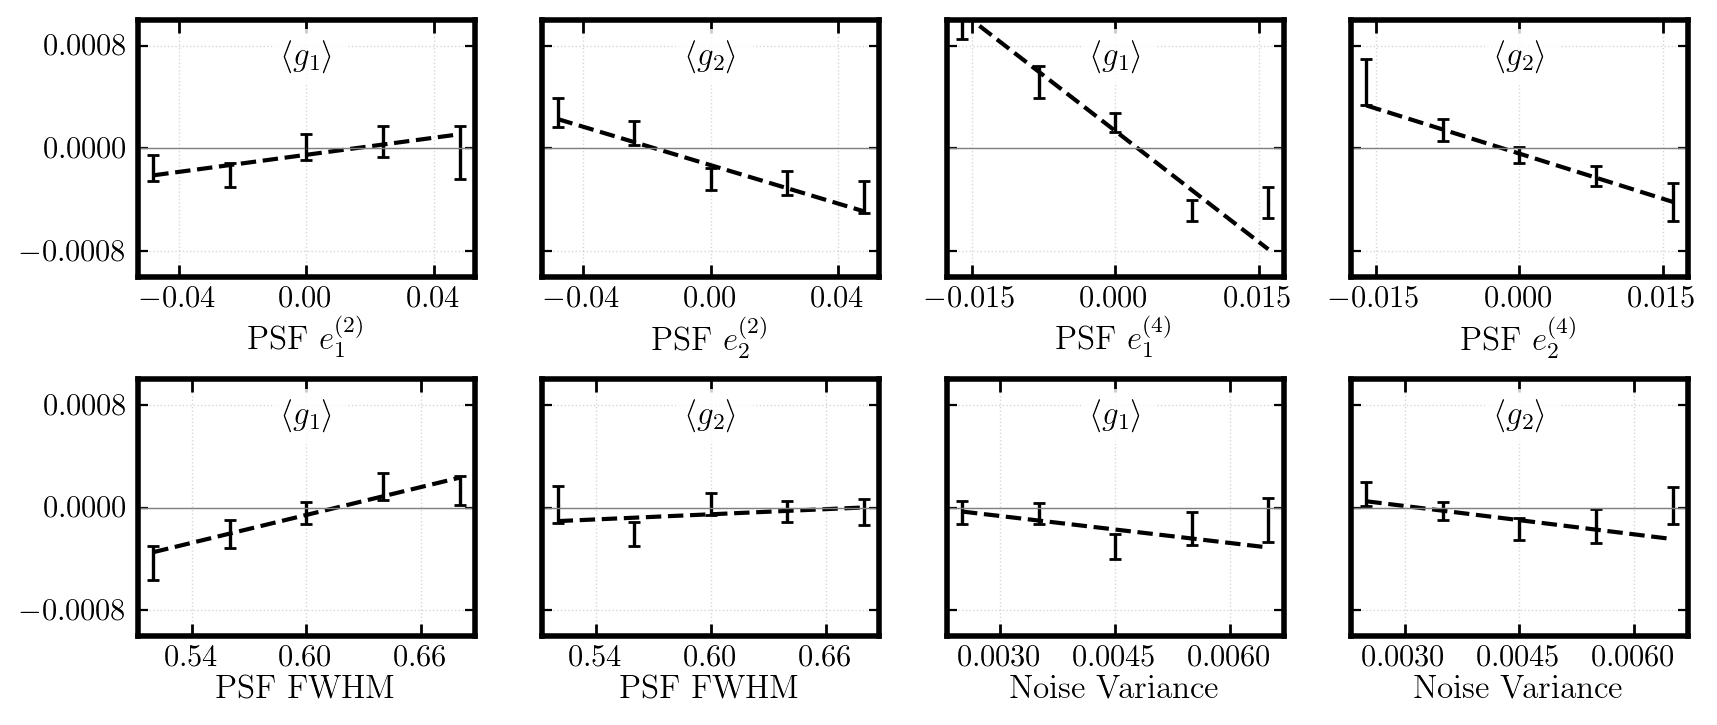

In [7]:
# Construct x_data
x_data = np.vstack([
    tab["e_psf_2"], tab["e_psf_2"],
    tab["e_psf_4"], tab["e_psf_4"],
    tab["size"],      tab["size"],
    tab["var"],       tab["var"]
])

# Construct y_data and y_errs from the ave/std dicts
pairs = [
    ("ave1_2", "std1_2"),
    ("ave2_2", "std2_2"),
    ("ave1_4", "std1_4"),
    ("ave2_4", "std2_4"),
    ("ave1_s", "std1_s"),
    ("ave2_s", "std2_s"),
    ("ave1_v", "std1_v"),
    ("ave2_v", "std2_v")
]

y_data = np.vstack([ave[k] for k, _ in pairs])
y_errs = np.vstack([std[k] for _, k in pairs])

# Prepare figure
fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharey='row', gridspec_kw={'hspace': 0.4})
axes = axes.flatten()

# Titles and X-labels
titles = [r'$\langle g_1 \rangle$', r'$\langle g_2 \rangle$'] * 4
xlabels = [
    r'PSF $e_1^{(2)}$', r'PSF $e_2^{(2)}$',
    r'PSF $e_1^{(4)}$', r'PSF $e_2^{(4)}$',
    'PSF FWHM', 'PSF FWHM',
    'Noise Variance', 'Noise Variance'
]

# Loop over panels
for i, ax in enumerate(axes):
    x = x_data[i]
    y = y_data[i]
    yerr = y_errs[i]

    ax.errorbar(x, y, yerr=yerr, fmt='s', color='black', markersize=0.1, capsize=2, linewidth=1.2)

    # Linear fit with inverse variance weighting
    coeffs, cov = np.polyfit(x, y, deg=1, w=1.0/ yerr**2., cov=True)
    print(coeffs)
    xfit = np.linspace(np.min(x), np.max(x), 100)
    ax.plot(xfit, np.polyval(coeffs, xfit), ls='--', color="black", linewidth=1.5)

    ax.axhline(0, color='gray', linewidth=0.5)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

    ax.text(0.43, 0.92, titles[i], transform=ax.transAxes,
            fontsize=12, va='top', ha='left',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
    ax.set_xlabel(xlabels[i], fontsize=12, labelpad=1)
    ax.set_ylim(-0.001, 0.001)
    ax.tick_params(labelsize=11)
plt.show()

[-2.80501121e-03 -6.04670217e-05]
[-0.01407286 -0.00020564]
[-0.04863025  0.00018737]
[-1.19883232e-02 -6.66635483e-05]
[ 0.00316182 -0.00183633]
[ 0.00041013 -0.00028766]
[-1.43769418e-02  2.98724554e-05]
[-0.07704981  0.00023782]


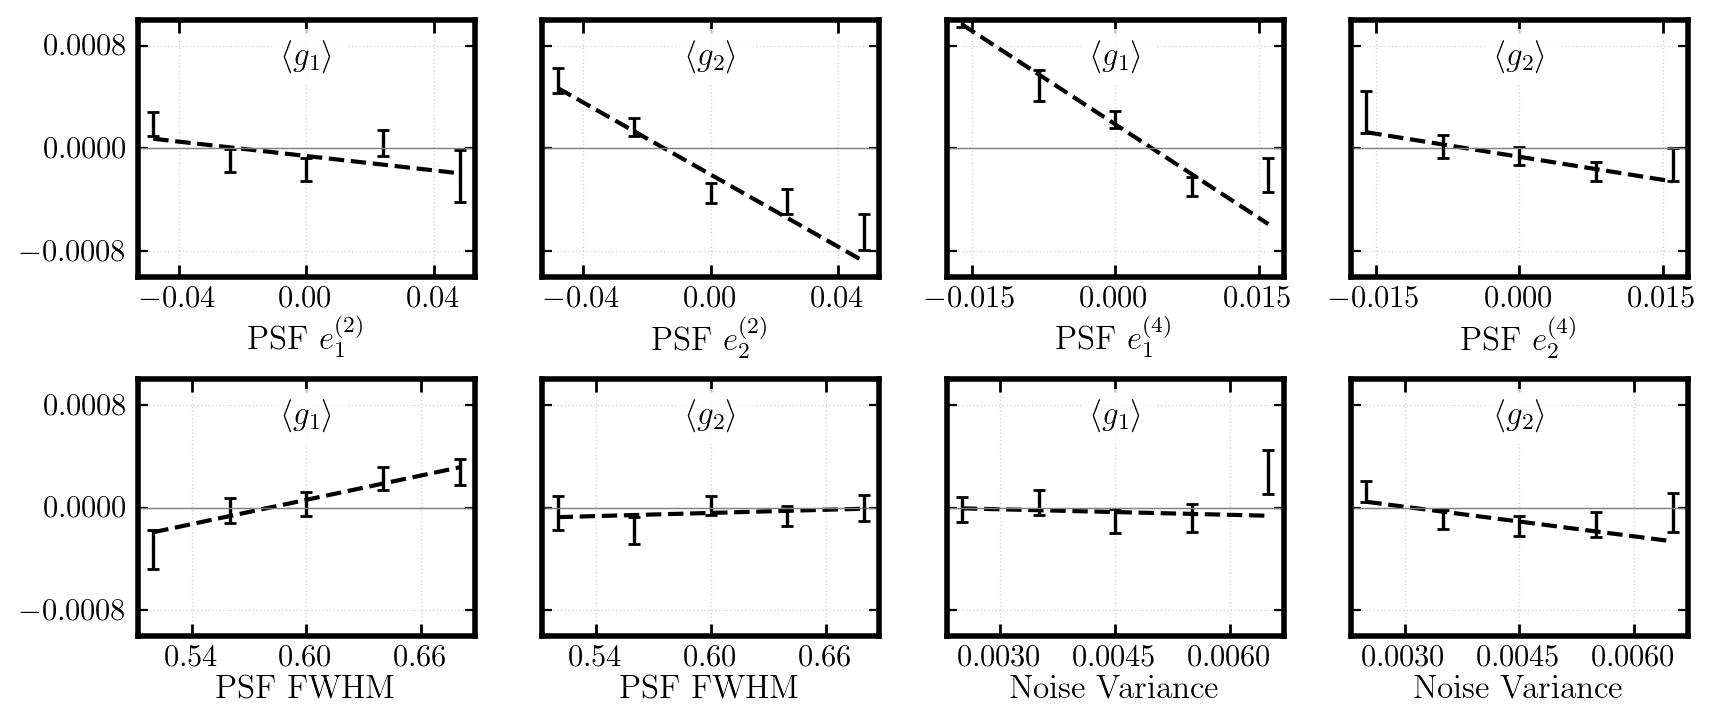

In [16]:
# Construct x_data
x_data = np.vstack([
    tab["e_psf_2"], tab["e_psf_2"],
    tab["e_psf_4"], tab["e_psf_4"],
    tab["size"],      tab["size"],
    tab["var"],       tab["var"]
])

# Construct y_data and y_errs from the ave/std dicts
pairs = [
    ("ave1_2", "std1_2"),
    ("ave2_2", "std2_2"),
    ("ave1_4", "std1_4"),
    ("ave2_4", "std2_4"),
    ("ave1_s", "std1_s"),
    ("ave2_s", "std2_s"),
    ("ave1_v", "std1_v"),
    ("ave2_v", "std2_v")
]

y_data = np.vstack([ave[k] for k, _ in pairs])
y_errs = np.vstack([std[k] for _, k in pairs])

# Prepare figure
fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharey='row', gridspec_kw={'hspace': 0.4})
axes = axes.flatten()

# Titles and X-labels
titles = [r'$\langle g_1 \rangle$', r'$\langle g_2 \rangle$'] * 4
xlabels = [
    r'PSF $e_1^{(2)}$', r'PSF $e_2^{(2)}$',
    r'PSF $e_1^{(4)}$', r'PSF $e_2^{(4)}$',
    'PSF FWHM', 'PSF FWHM',
    'Noise Variance', 'Noise Variance'
]

# Loop over panels
for i, ax in enumerate(axes):
    x = x_data[i]
    y = y_data[i]
    yerr = y_errs[i]

    ax.errorbar(x, y, yerr=yerr, fmt='s', color='black', markersize=0.1, capsize=2, linewidth=1.2)

    # Linear fit with inverse variance weighting
    coeffs, cov = np.polyfit(x, y, deg=1, w=1.0/ yerr**2., cov=True)
    print(coeffs)
    xfit = np.linspace(np.min(x), np.max(x), 100)
    ax.plot(xfit, np.polyval(coeffs, xfit), ls='--', color="black", linewidth=1.5)

    ax.axhline(0, color='gray', linewidth=0.5)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

    ax.text(0.43, 0.92, titles[i], transform=ax.transAxes,
            fontsize=12, va='top', ha='left',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
    ax.set_xlabel(xlabels[i], fontsize=12, labelpad=1)
    ax.set_ylim(-0.001, 0.001)
    ax.tick_params(labelsize=11)
plt.show()

[-0.00404926 -0.00012073]
[-0.01558947  0.00023743]
[-0.04458824  0.00017295]
[-1.41076705e-02  8.06376795e-05]
[ 0.00377313 -0.00224176]
[-0.00054885  0.0004042 ]
[-1.35856384e-02 -7.39728817e-06]
[ 0.07493572 -0.00021009]


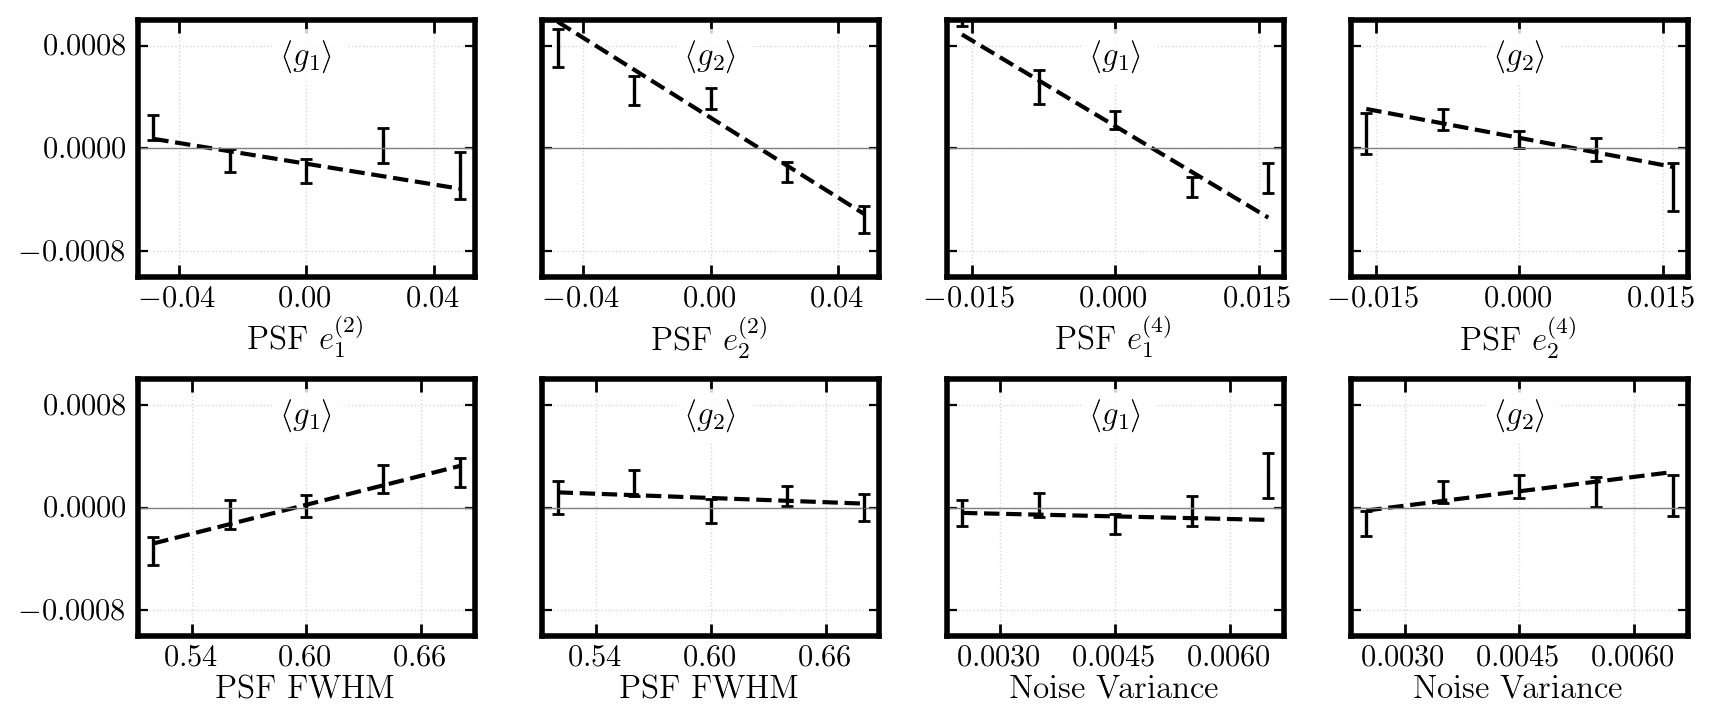

In [4]:
# Construct x_data
x_data = np.vstack([
    tab["e_psf_2"], tab["e_psf_2"],
    tab["e_psf_4"], tab["e_psf_4"],
    tab["size"],      tab["size"],
    tab["var"],       tab["var"]
])

# Construct y_data and y_errs from the ave/std dicts
pairs = [
    ("ave1_2", "std1_2"),
    ("ave2_2", "std2_2"),
    ("ave1_4", "std1_4"),
    ("ave2_4", "std2_4"),
    ("ave1_s", "std1_s"),
    ("ave2_s", "std2_s"),
    ("ave1_v", "std1_v"),
    ("ave2_v", "std2_v")
]

y_data = np.vstack([ave[k] for k, _ in pairs])
y_errs = np.vstack([std[k] for _, k in pairs])

# Prepare figure
fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharey='row', gridspec_kw={'hspace': 0.4})
axes = axes.flatten()

# Titles and X-labels
titles = [r'$\langle g_1 \rangle$', r'$\langle g_2 \rangle$'] * 4
xlabels = [
    r'PSF $e_1^{(2)}$', r'PSF $e_2^{(2)}$',
    r'PSF $e_1^{(4)}$', r'PSF $e_2^{(4)}$',
    'PSF FWHM', 'PSF FWHM',
    'Noise Variance', 'Noise Variance'
]

# Loop over panels
for i, ax in enumerate(axes):
    x = x_data[i]
    y = y_data[i]
    yerr = y_errs[i]

    ax.errorbar(x, y, yerr=yerr, fmt='s', color='black', markersize=0.1, capsize=2, linewidth=1.2)

    # Linear fit with inverse variance weighting
    coeffs, cov = np.polyfit(x, y, deg=1, w=1.0/ yerr**2., cov=True)
    print(coeffs)
    xfit = np.linspace(np.min(x), np.max(x), 100)
    ax.plot(xfit, np.polyval(coeffs, xfit), ls='--', color="black", linewidth=1.5)

    ax.axhline(0, color='gray', linewidth=0.5)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

    ax.text(0.43, 0.92, titles[i], transform=ax.transAxes,
            fontsize=12, va='top', ha='left',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
    ax.set_xlabel(xlabels[i], fontsize=12, labelpad=1)
    ax.set_ylim(-0.001, 0.001)
    ax.tick_params(labelsize=11)
plt.show()

In [5]:
# Parameters
n_samples = 1000
degree = 1
for i in range(4):
    x = x_data[i]
    y = y_data[i]
    yerr = y_errs[i]
    fit_params = np.zeros((n_samples, degree + 1))
    for i in range(n_samples):
        y_sample = np.random.normal(loc=y, scale=yerr)
        coeffs = np.polyfit(x, y_sample, deg=degree, w= 1.0 / yerr**2.0)
        fit_params[i] = coeffs
    param_std = np.std(fit_params, axis=0)
    print(param_std)

[1.93012835e-03 6.02167352e-05]
[1.63866373e-03 4.61400372e-05]
[7.25429912e-03 5.85554508e-05]
[6.26141133e-03 4.63580838e-05]
